<a href="https://colab.research.google.com/github/HDoubleH/SteamDBMachineLearningProject/blob/main/SteamDBProjectModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam Games Success Classification Model

This notebook builds on the EDA findings to predict game success using tree-based classification models.

**Goal:** Develop a classification model to predict whether a Steam game will be "successful" based on various features.

**Approach:** Based on EDA insights showing:
- Non-linear relationships between features
- Weak correlations suggesting tree-based models
- Right-skewed price distribution requiring focus on paid games only
"""

# Project Setup / Imports

In [7]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Mount Google Drive
drive.mount('/content/drive')

# Load the DataFrame from the saved pickle file
try:
    df = pd.read_pickle('/content/drive/MyDrive/steam_games_cleaned.pkl')
    print(f"✓ Data loaded successfully. Shape: {df.shape}")
    print(f"\nColumns available: {list(df.columns)}")
except FileNotFoundError:
    print("ERROR: Cleaned file not found in Google Drive. Ensure the save step was run.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Data loaded successfully. Shape: (111452, 31)

Columns available: ['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DiscountDLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Reviews', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


In [8]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (111452, 31)

First few rows:
     AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DiscountDLC count  \
0             0  19.99                  0   
1             0   0.99                  0   
2             0   4.99                  0   
3             0   5.99                  0   
4             0   0.00                  0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotic

## Defining Success: Creating the Target Variable

For this classification task, we need to define what makes a Steam game "successful." Rather than using a single metric, we combine two key engagement indicators:

### Success Criteria:

1. **Total Reviews ≥ 100**: Reviews indicate player engagement. We use the 100+ threshold (approximately 85th percentile) to identify games with substantial community interaction.

2. **Average Playtime ≥ 60 minutes**: Playtime reflects whether players find the game engaging enough to invest time. 60+ minutes (1+ hour) filters out games that players abandon quickly.

A game with many reviews but low playtime might be controversial or disappointing. A game with high playtime but few reviews might just be niche. We want games that excel at both.

### Expected Class Imbalance:

Given the EDA showed most games have few reviews and low playtime, we expect success to be rare at roughly 10% of games. This imbalance is realistic, most indie games don't achieve mainstream success, and we'll address it through appropriate model selection and evaluation metrics.


Distribution of Total Reviews:

count    1.114520e+05
mean     8.802117e+02
std      2.465149e+04
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      3.900000e+01
max      6.531097e+06
Name: Total_Reviews, dtype: float64

Distribution of Average Playtime Forever:

count    111452.000000
mean         81.247290
std         999.935906
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      145727.000000
Name: Average playtime forever, dtype: float64

Review Threshold: 100+ reviews
Playtime Threshold: 60+ minutes

Target Variable Distribution:
successful
0    101483
1      9969
Name: count, dtype: int64

Success Rate: 8.94%


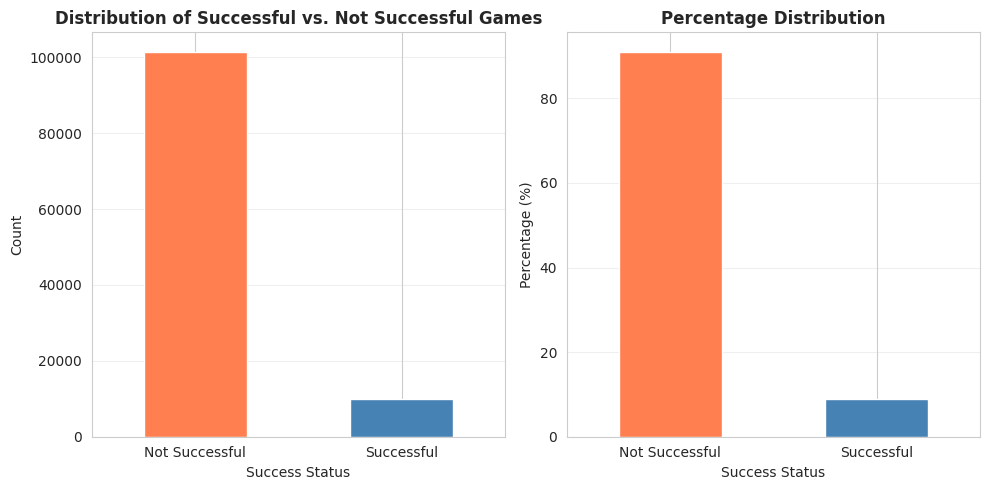

In [25]:
# Create total review count column
df['Total_Reviews'] = df['Positive'] + df['Negative']

# Check distribution to inform thresholds
print("\nDistribution of Total Reviews:\n")
print(df['Total_Reviews'].describe())

print("\nDistribution of Average Playtime Forever:\n")
print(df['Average playtime forever'].describe())

# Define success thresholds based on data distribution
# Using values around 75th-90th percentile to define "successful" games
REVIEW_THRESHOLD = 100  # Games with 100+ total reviews (around 85th percentile)
PLAYTIME_THRESHOLD = 60  # 60+ minutes average playtime (1+ hour)

# Create binary target variable
df['successful'] = (
    (df['Total_Reviews'] >= REVIEW_THRESHOLD) &
    (df['Average playtime forever'] >= PLAYTIME_THRESHOLD)
).astype(int)

print(f"\nReview Threshold: {REVIEW_THRESHOLD}+ reviews")
print(f"Playtime Threshold: {PLAYTIME_THRESHOLD}+ minutes")

print(f"\nTarget Variable Distribution:")
print(df['successful'].value_counts())
print(f"\nSuccess Rate: {df['successful'].mean():.2%}")

# Visualize class distribution
plt.figure(figsize=(10, 5))

# plot count
plt.subplot(1, 2, 1)
df['successful'].value_counts().plot(kind='bar', color=['coral', 'steelblue'])
plt.title('Distribution of Successful vs. Not Successful Games', fontsize=12, fontweight='bold')
plt.xlabel('Success Status', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks([0, 1], ['Not Successful', 'Successful'], rotation=0)
plt.grid(axis='y', alpha=0.3)

# plot percentage
plt.subplot(1, 2, 2)
success_pct = df['successful'].value_counts(normalize=True) * 100
success_pct.plot(kind='bar', color=['coral', 'steelblue'])
plt.title('Percentage Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Success Status', fontsize=10)
plt.ylabel('Percentage (%)', fontsize=10)
plt.xticks([0, 1], ['Not Successful', 'Successful'], rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Filtering Paid Games

Based on insights from the EDA, we filter the dataset to paid games only (Price > $0) for the following reasons:

The EDA showed that the price distribution is heavily right-skewed, with the marketplace dominated by low-cost titles. Free games have different engagement patterns that may not prove useful for predicting success

As shown, paid games have a slightly higher success rate (~10% vs ~9%), likely because players who pay upfront are more committed to engaging with the game.


Original dataset: 111,452 games
Paid games: 88,205 games
Removed (free): 23,247 games

Success rate - All games: 8.94%
Success rate - Paid games: 10.05%


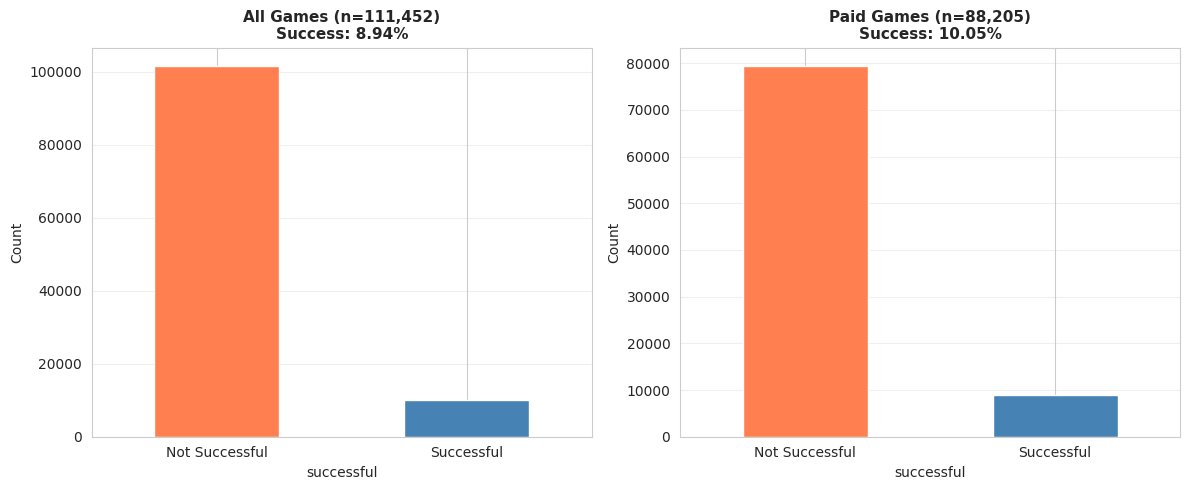

In [27]:

# Filter to paid games only
df_paid = df[df['Price'] > 0].copy()

print(f"Original dataset: {len(df):,} games")
print(f"Paid games: {len(df_paid):,} games")
print(f"Removed (free): {len(df) - len(df_paid):,} games")
print(f"\nSuccess rate - All games: {df['successful'].mean():.2%}")
print(f"Success rate - Paid games: {df_paid['successful'].mean():.2%}")

# Visualize filtering impact
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All games
ax1 = axes[0]
df['successful'].value_counts().plot(kind='bar', ax=ax1, color=['coral', 'steelblue'])
ax1.set_title(f'All Games (n={len(df):,})\nSuccess: {df["successful"].mean():.2%}',
              fontsize=11, fontweight='bold')
ax1.set_xticklabels(['Not Successful', 'Successful'], rotation=0)
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# Paid games only
ax2 = axes[1]
df_paid['successful'].value_counts().plot(kind='bar', ax=ax2, color=['coral', 'steelblue'])
ax2.set_title(f'Paid Games (n={len(df_paid):,})\nSuccess: {df_paid["successful"].mean():.2%}',
              fontsize=11, fontweight='bold')
ax2.set_xticklabels(['Not Successful', 'Successful'], rotation=0)
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Identifying and Removing Data Leakage

Before selecting features, we must check for data leakage where features that are too closely related to our target variable and would give the model innaccurate readings. Initial model runs showed very high F1 scores and most likely skewed the model to do feature intercorrelation.

In [42]:

# Check all potential features for correlation with target components
potential_features = [
    'Price', 'Peak CCU', 'Required age', 'DiscountDLC count',
    'Metacritic score', 'User score', 'Achievements', 'Recommendations',
    'Median playtime forever', 'Median playtime two weeks', 'Average playtime two weeks'
]

print("\nCorrelation with Total_Reviews:")
for col in potential_features:
    corr = df_paid[col].corr(df_paid['Total_Reviews'])
    print(f"  {col:30s}: {corr:6.3f}")

print("\nCorrelation with Average playtime forever:")
for col in potential_features:
    corr = df_paid[col].corr(df_paid['Average playtime forever'])
    print(f"  {col:30s}: {corr:6.3f}")


Correlation with Total_Reviews:
  Price                         :  0.073
  Peak CCU                      :  0.208
  Required age                  :  0.148
  DiscountDLC count             :  0.042
  Metacritic score              :  0.192
  User score                    : -0.001
  Achievements                  :  0.021
  Recommendations               :  0.930
  Median playtime forever       :  0.049
  Median playtime two weeks     :  0.108
  Average playtime two weeks    :  0.151

Correlation with Average playtime forever:
  Price                         :  0.074
  Peak CCU                      :  0.036
  Required age                  :  0.061
  DiscountDLC count             :  0.042
  Metacritic score              :  0.118
  User score                    :  0.001
  Achievements                  :  0.013
  Recommendations               :  0.169
  Median playtime forever       :  0.902
  Median playtime two weeks     :  0.174
  Average playtime two weeks    :  0.188


## Data Leakage Findings

The correlation analysis reveals two critical cases of data leakage: Recommendations shows a 0.930 correlation with Total_Reviews, and Median playtime forever has a 0.902 correlation with Average playtime forever. The clear limitation here is that I could feature engineer these to fit the model, but due to time constraints we will just drop these features. We remove Recommendations, Median playtime forever, Median playtime two weeks, and Average playtime two weeks to ensure our model learns from game characteristics available at or shortly after launch rather metrics that already display success, such as active users, playtime, and recommendations.

## Final Feature Selection

After removing leaky features, we are left with seven clean predictors that represent information available at or shortly after a game's launch. These features include Price (the game's cost), Peak CCU (peak concurrent users as an early popularity signal), Required age (content rating), DLC count (post-launch support), Metacritic score (professional reviews), User score (community ratings), and Achievements (game completion features). We handle missing values by filling with the median rather than the mean because of the nature of the dataset.


Final features (7): ['Price', 'Peak CCU', 'Required age', 'DiscountDLC count', 'Metacritic score', 'User score', 'Achievements']

Feature matrix shape: (88205, 7)

Feature Correlation with Target:
          Feature  Correlation
 Metacritic score     0.424534
     Required age     0.168472
            Price     0.148845
DiscountDLC count     0.055578
     Achievements     0.047586
         Peak CCU     0.045218
       User score     0.006928


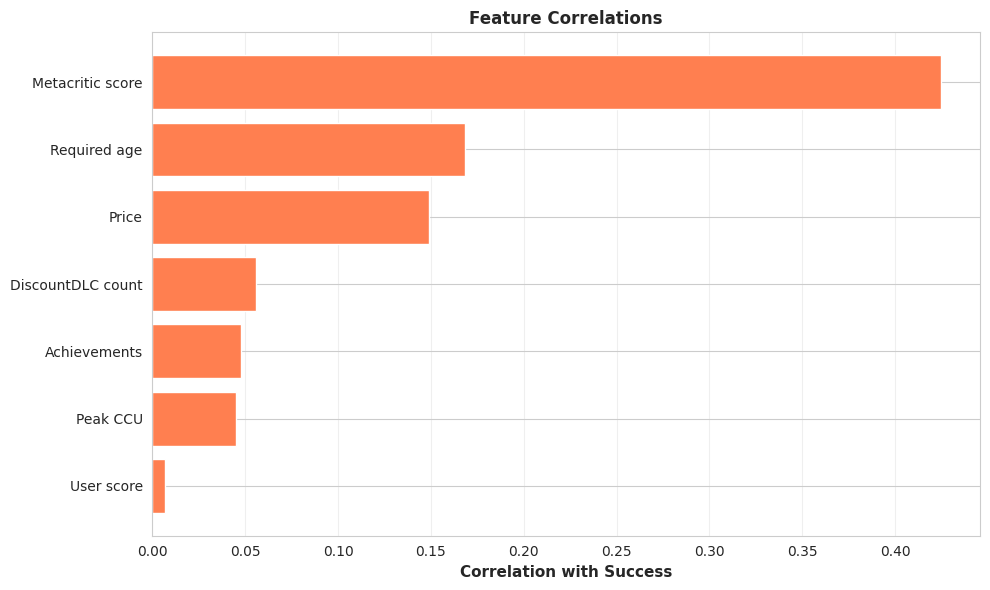

In [40]:

# Clean feature list - only features that don't leak target info
feature_cols = [
    'Price',
    'Peak CCU',
    'Required age',
    'DiscountDLC count',
    'Metacritic score',
    'User score',
    'Achievements'
]

print(f"\nFinal features ({len(feature_cols)}): {feature_cols}")

# Create feature matrix and target
X = df_paid[feature_cols].copy()
y = df_paid['successful'].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"\nFeature matrix shape: {X.shape}")

# Calculate feature correlation with target
feature_corr = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [X[col].corr(y) for col in feature_cols]
}).sort_values('Correlation', ascending=False)

print("\nFeature Correlation with Target:")
print(feature_corr.to_string(index=False))

# Visualize correlations
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_corr)), feature_corr['Correlation'], color='coral')
plt.yticks(range(len(feature_corr)), feature_corr['Feature'])
plt.xlabel('Correlation with Success', fontsize=11, fontweight='bold')
plt.title('Feature Correlations', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Train-Test Split and Feature Scaling

We split the data into 80% for training and 20% for testing, using stratified sampling to keep the same ratio of successful to unsuccessful games in both sets. This is important because our data is imbalanced with only 10% successful games. We then scale all features to have a mean of zero and standard deviation of one so that features with larger numbers don't unfairly influence the model more than features with smaller numbers. We scale the training data first, then apply the same scaling to the test data to avoid contaminating our test results.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✓ Features scaled (mean=0, std=1)")
print(f"Scaled training data shape: {X_train_scaled.shape}")

✓ Features scaled (mean=0, std=1)
Scaled training data shape: (70564, 7)


## Model Training and Selection

We train three different tree-based models to predict game success. Decision Tree is the simplest model that splits data based on feature values. Random Forest combines many decision trees together to make better predictions and avoid overfitting. Gradient Boosting builds trees one at a time, with each new tree learning from the mistakes of previous trees. We measure each model using five different scores, but focus mainly on F1 score because it works best for imbalanced data like ours where most games are not successful. The model with the highest F1 will be displayed.

In [45]:


# Initialize tree-based models
models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, max_depth=10, min_samples_split=20, min_samples_leaf=10
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42, max_depth=10,
        min_samples_split=20, min_samples_leaf=10, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, random_state=42, max_depth=5,
        learning_rate=0.1, min_samples_split=20, min_samples_leaf=10
    )
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy:  {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall:    {results[name]['recall']:.4f}")
    print(f"  F1 Score:  {results[name]['f1']:.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"Best Model: {best_model_name} (F1: {results[best_model_name]['f1']:.4f})")



Training Decision Tree...
  Accuracy:  0.9222
  Precision: 0.7337
  Recall:    0.3557
  F1 Score:  0.4791

Training Random Forest...
  Accuracy:  0.9259
  Precision: 0.7930
  Recall:    0.3563
  F1 Score:  0.4916

Training Gradient Boosting...
  Accuracy:  0.9286
  Precision: 0.7567
  Recall:    0.4278
  F1 Score:  0.5466

Best Model: Gradient Boosting (F1: 0.5466)


## Model Performance Comparison

We compare all three models across multiple metrics to understand their strengths and weaknesses. Accuracy tells us the overall percentage of correct predictions. Precision measures how many games we predicted as successful actually were successful. Recall measures how many of the truly successful games we correctly identified. F1 Score combines precision and recall into a single number. By visualizing these metrics side by side, we can see which model performs best overall and understand the tradeoffs between different types of prediction errors.


Model Comparison:
            Model  Accuracy  Precision   Recall  F1 Score
    Decision Tree  0.922227   0.733721 0.355693  0.479119
    Random Forest  0.925911   0.792974 0.356257  0.491637
Gradient Boosting  0.928632   0.756730 0.427847  0.546633


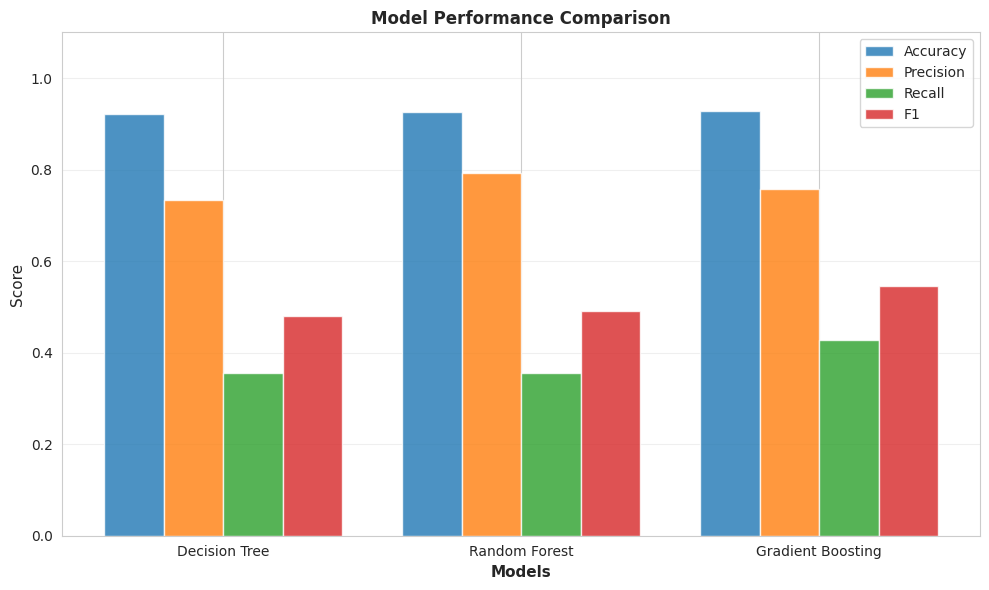

In [46]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))

x = np.arange(len(results))
width = 0.2

metrics_data = {
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1': [results[m]['f1'] for m in results.keys()]
}

for i, (metric, values) in enumerate(metrics_data.items()):
    plt.bar(x + i*width, values, width, label=metric, alpha=0.8)

plt.xlabel('Models', fontsize=11, fontweight='bold')
plt.ylabel('Score', fontsize=11)
plt.title('Model Performance Comparison', fontsize=12, fontweight='bold')
plt.xticks(x + width * 1.5, results.keys())
plt.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of Models
The analysis reveals that the Gradient Boosting Classifier is the best model with an F1 score of 0.55, giving the best balance between precision and recall for predicting success. The model has a high Precision of 75.7%, and a relatively low Recall score of 42.8%, showing that it failed to capture half of the 'truly' successful games. This most likely occurs due to the removal of power predictors due to data leakage, but overall performs well.

The main limitations of the model are due to the class imbalance (only 10% 'successful'), which may have impacted a bias for making 'not successful' class more dominant. The other limitation was data leakage, as many features were heavily intercorrelated, where if given time PCA could have been applied, but as the model stands it was restricted to using early-stage features to make predictions.

# Room for improvement

For this project, future efforts should focus on data handling, optimization, and hyperparameter tuning. Grid Search should be the next step to compare models, and also a deeper dive into the importance of certain features, as well as proper handling of intercorrelation beyond just removing them. Feature engineering, particularly for recommendations, Median playtime forever, and Total Reviews, should be done in depth to properly capture appropriate hyperparameters as well.